In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0518'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
TS_IN=8
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5268,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7902,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9219,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3951,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10536,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11853,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2634,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13170,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14487,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


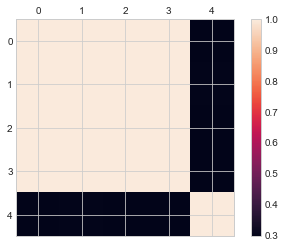

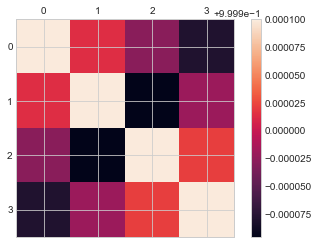

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

code 50


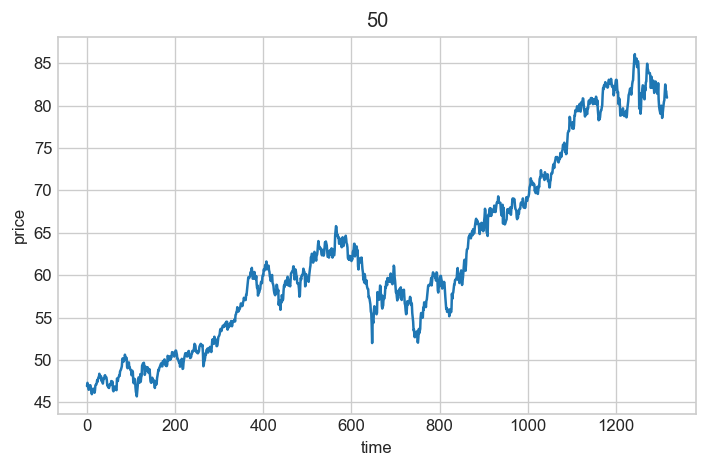

code 51


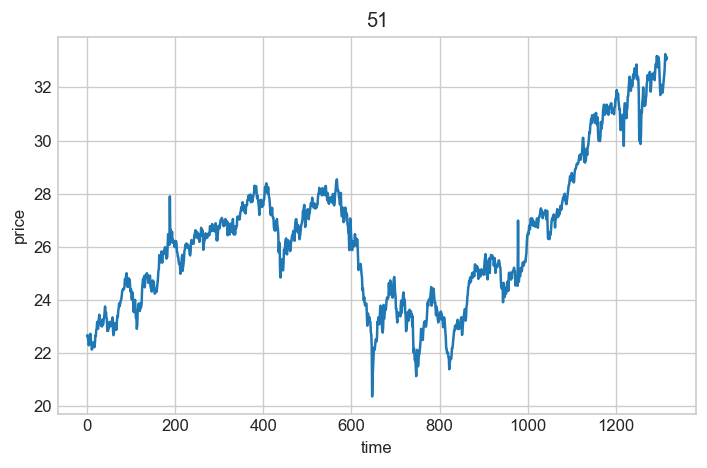

code 52


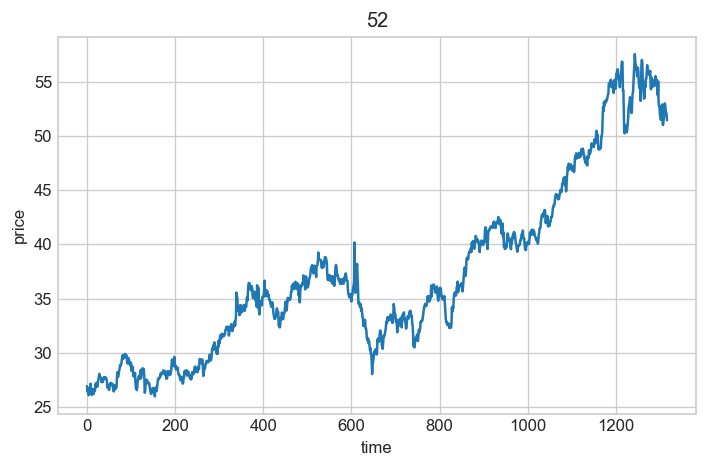

code 53


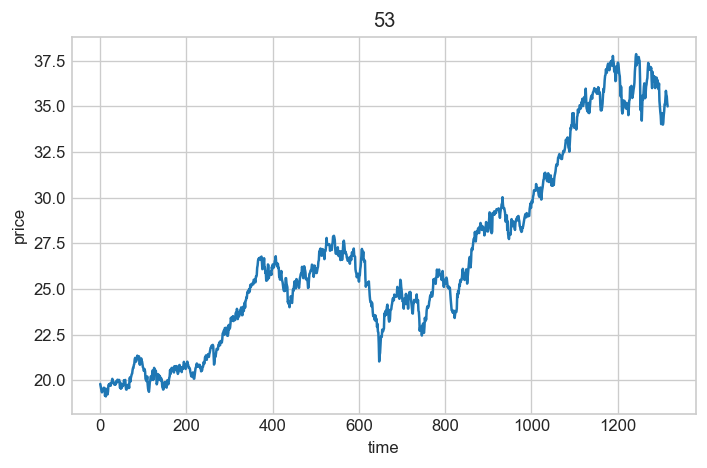

code 54


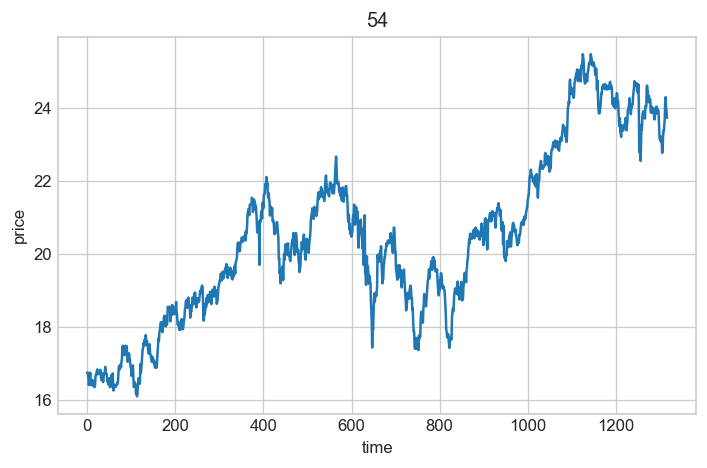

code 55


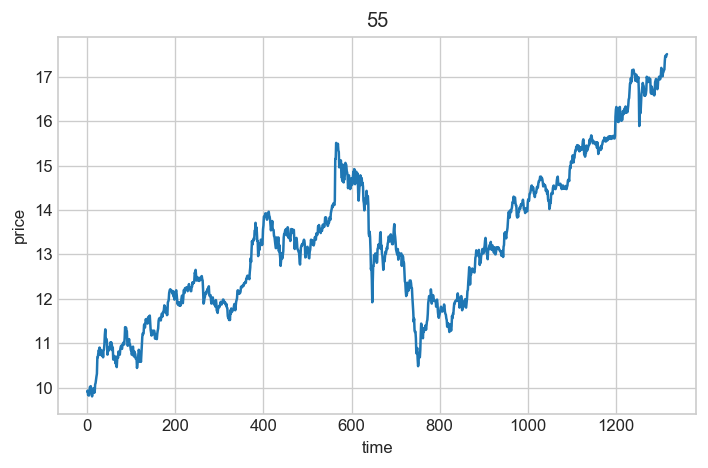

code 56


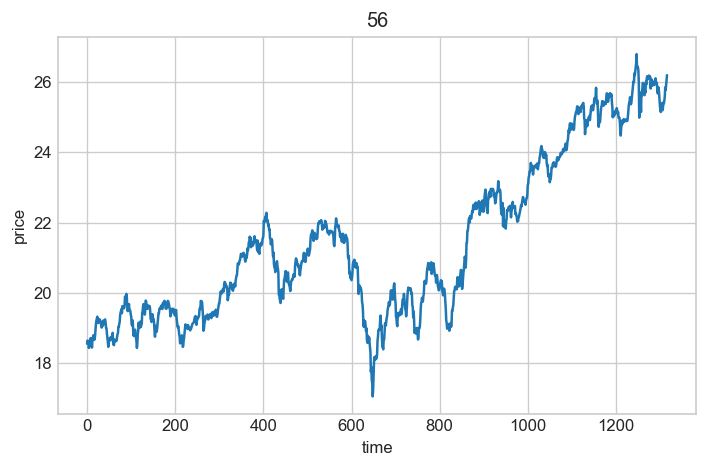

code 57


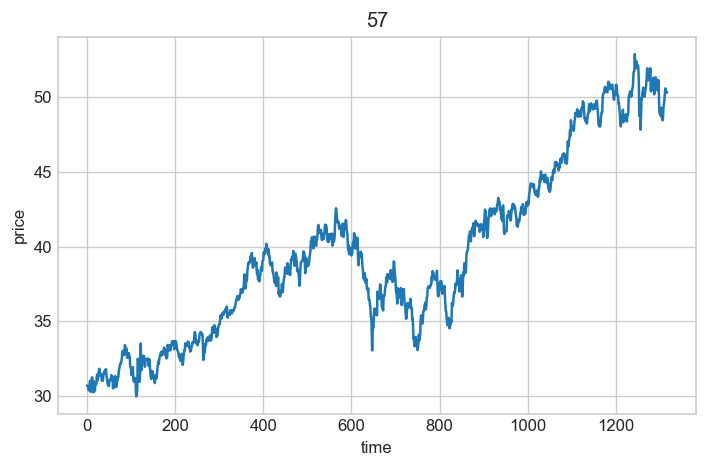

code 58


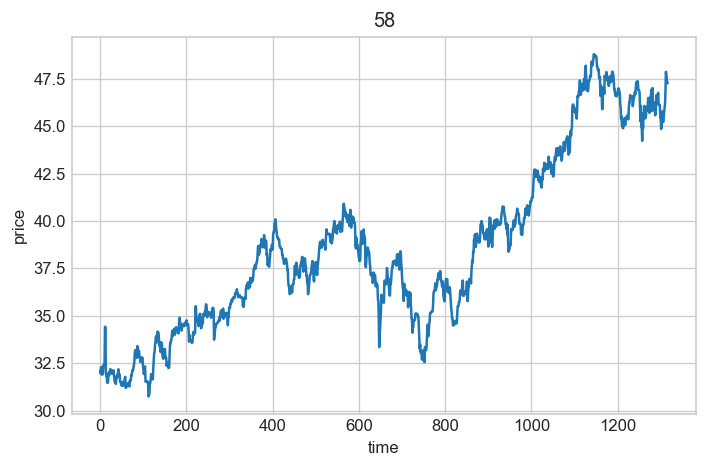

code 59


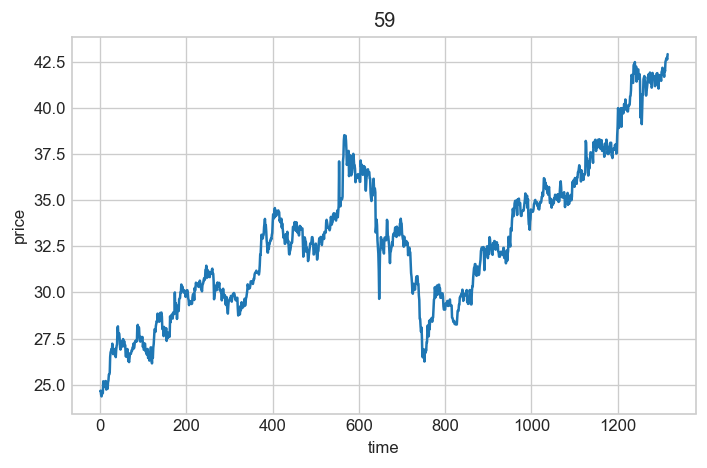

code 690


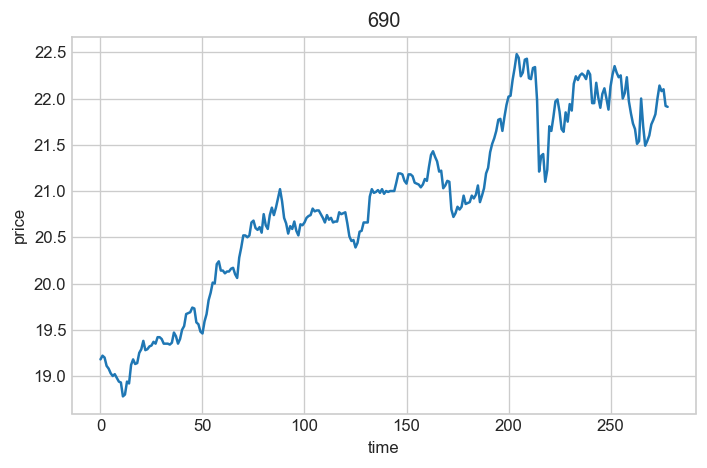

code 692


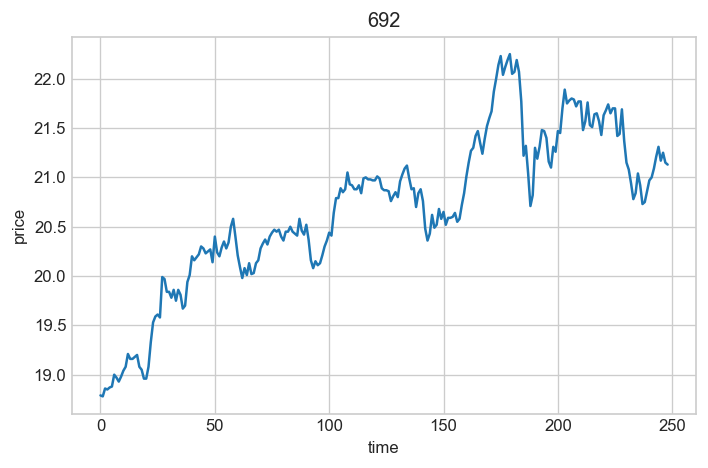

code 701


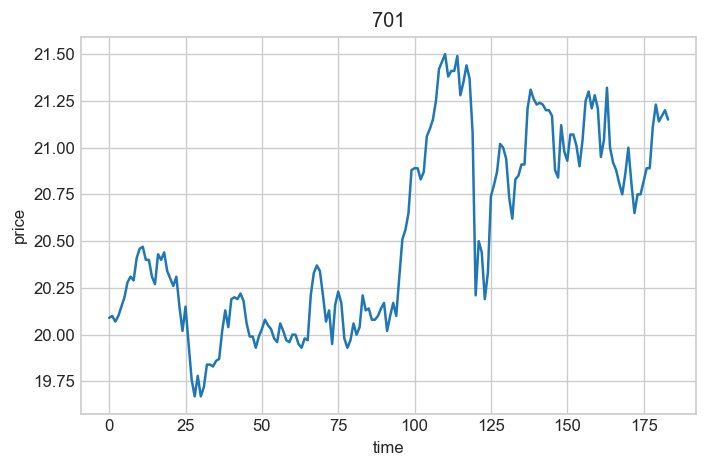

code 713


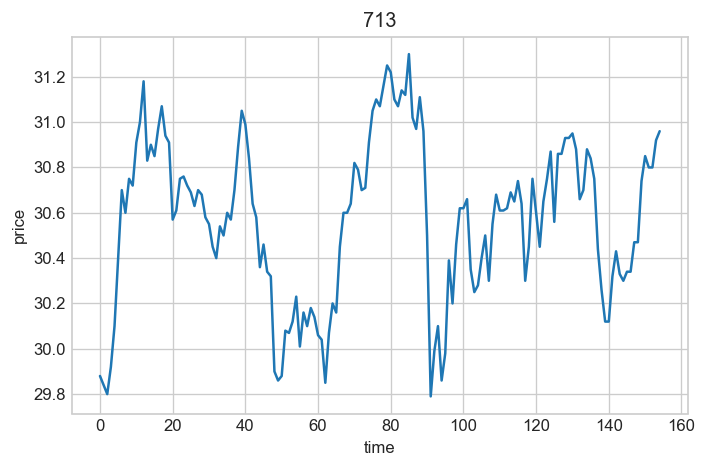

code 6201


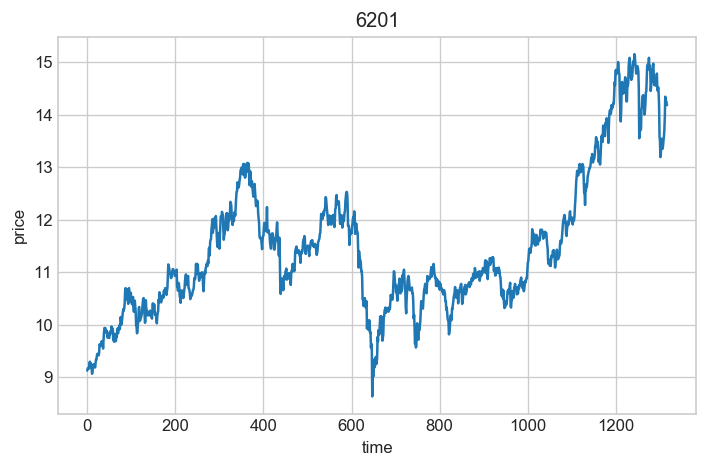

code 6203


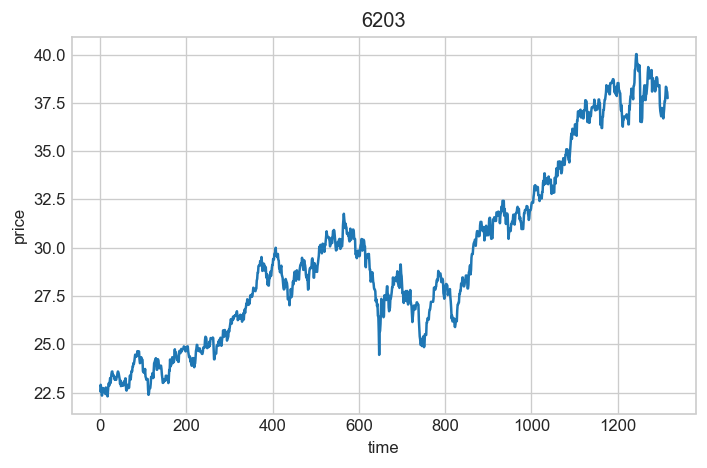

code 6204


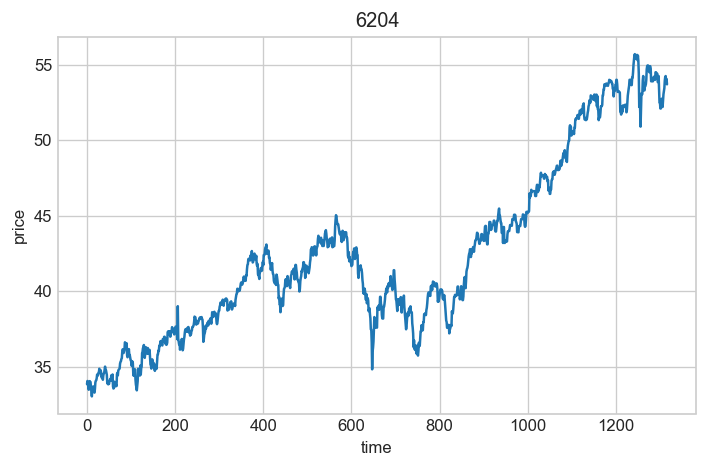

code 6208


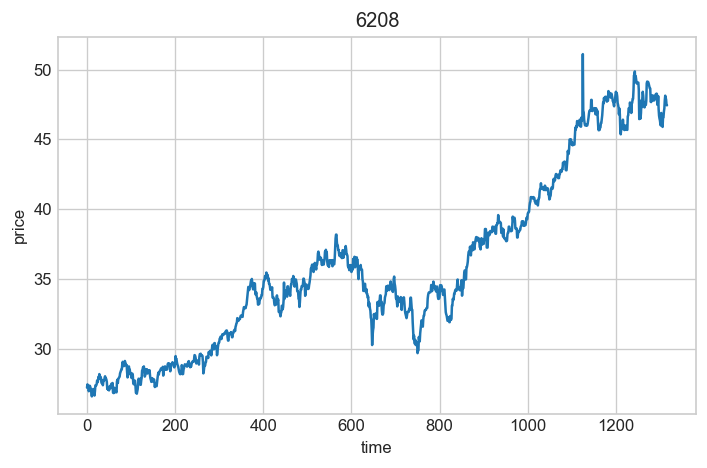

In [5]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    row = np.append(row, label, axis=-1)
    print('code {:d}'.format(code))
    fit, ax = plt.subplots(dpi=120)
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(range(row.shape[0]), row[...,fields_dict['收盤價(元)']])
    plt.tight_layout()
    plt.show()
    split_train.append(row)

In [6]:
for n, s in enumerate(split_train):
    print(codes[n], len(s))

50 1317
51 1317
52 1317
53 1317
54 1317
55 1317
56 1317
57 1317
58 1317
59 1317
690 279
692 249
701 184
713 155
6201 1317
6203 1317
6204 1317
6208 1317


In [7]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def classification_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    eq = K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32')
    return K.mean(K.sum(eq * weights, axis=-2))

def regress_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wmse = K.mean(K.sum(K.square(y_true-y_pred) * weights, axis=-2)) # mean squared error with weights
    return wmse

def classification_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wbce = K.mean(K.sum(K.binary_crossentropy(y_true, y_pred) * weights, axis=-2))
    return wbce

def regression_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    return K.mean(K.sum((y_true - K.abs(y_pred-y_true)) / (y_true+K.epsilon()) * weights, axis=-2))

def make_model(ts_in=60, ts_out=5, n_field=6, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a), activation='sigmoid'), name='class') (lstm_4)
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 6)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 128)          69632       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 128)       0           cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 5, 128)       132096      repeat_vector_1[0][0]            
__________________________________________________________________________________________________
cu_dnnlstm

In [8]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    Ys_label = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
        Ys_label.append(seq[i+ts_in:i+total_l, -1:]) # 漲跌
    return np.asarray(Xs), np.asarray(Ys), np.asarray(Ys_label)

In [9]:
train_18 = []
for seq in split_train:
    Xs, Ys, Ys_label = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys, Ys_label])

In [10]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    # r2, classification_score, regression_score, lb
    fig_, ax_ = plt.subplots(2, 3, dpi=80, figsize=(20, 5))
    ax = ax_.ravel()
    titles = ['wmse', 'wbce', 'r2', 'classification_score', 'regression_score', 'lb']
    for i, p in enumerate(titles):
        ax[i].set_title(title + ' ' + p + ' plot')
    for i in range(6):
        ax[i].set_xlabel('epoch')
    scores = ['wmse', 'wbce', 'r2', 'acc', 't_brain_regression', 'lb']
    for i, s in enumerate(scores):
        ax[i].set_ylabel(s)
    metric_names = ['regression_loss', 'class_loss', 'regression_r2_keras', 'class_classification_score', 'regression_regression_score']
    locs = [0, 0, 1, 1, 1]
    for i, (name, loc) in enumerate(zip(metric_names, locs)):
        ax[i].plot(history.history[name])
        ax[i].plot(history.history['val_'+name])
        ax[i].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    ax[-1].plot(0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score']))
    ax[-1].plot(0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score']))
    ax[-1].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    plt.tight_layout()
    plt.show()

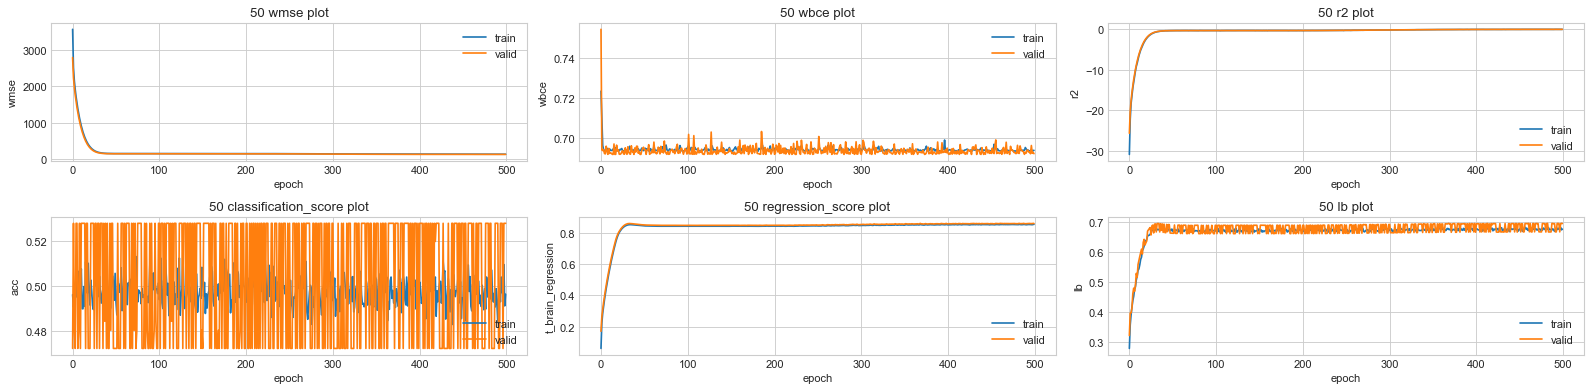

validation wbce: 0.691994
validation wmse: 114.887736
validation r2 : -0.049058
validation acc: 0.527778
validation regression: 0.860427
validation lb: 0.694102


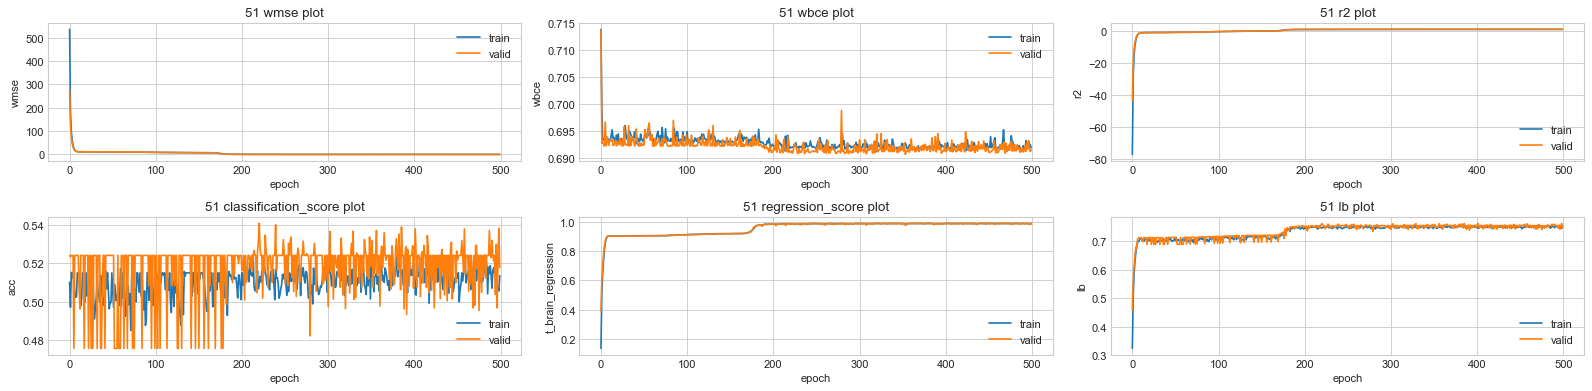

validation wbce: 0.691520
validation wmse: 0.390236
validation r2 : 0.935045
validation acc: 0.517816
validation regression: 0.982686
validation lb: 0.750251


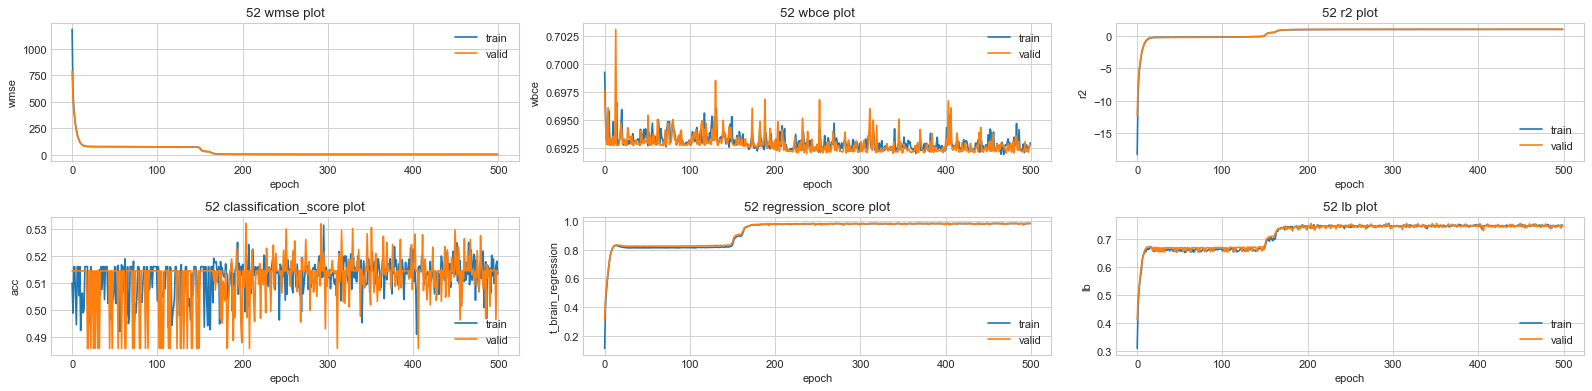

validation wbce: 0.692849
validation wmse: 1.210698
validation r2 : 0.975714
validation acc: 0.514368
validation regression: 0.981441
validation lb: 0.747904


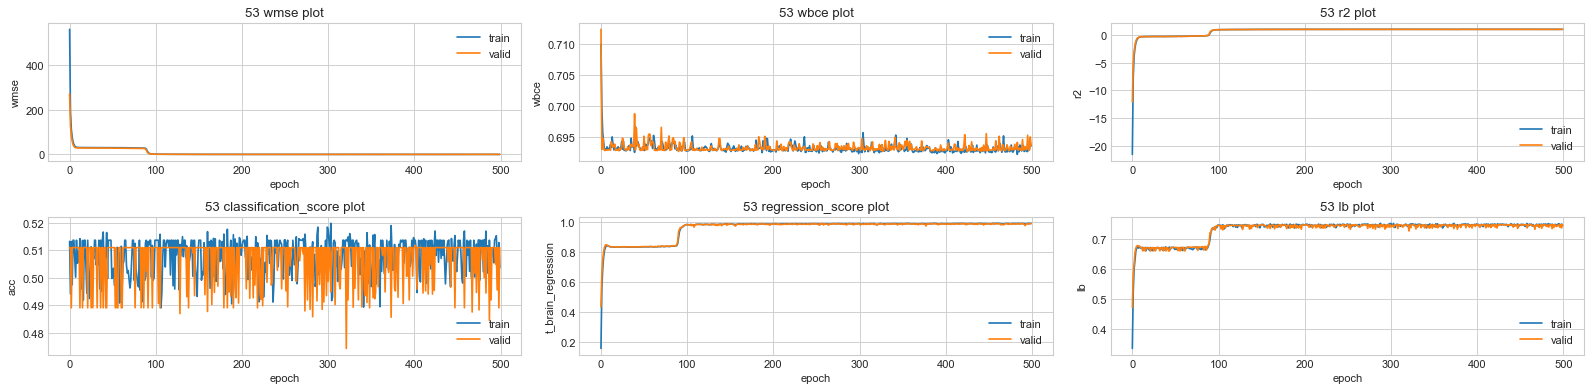

validation wbce: 0.693648
validation wmse: 0.298961
validation r2 : 0.984452
validation acc: 0.510920
validation regression: 0.986054
validation lb: 0.748487


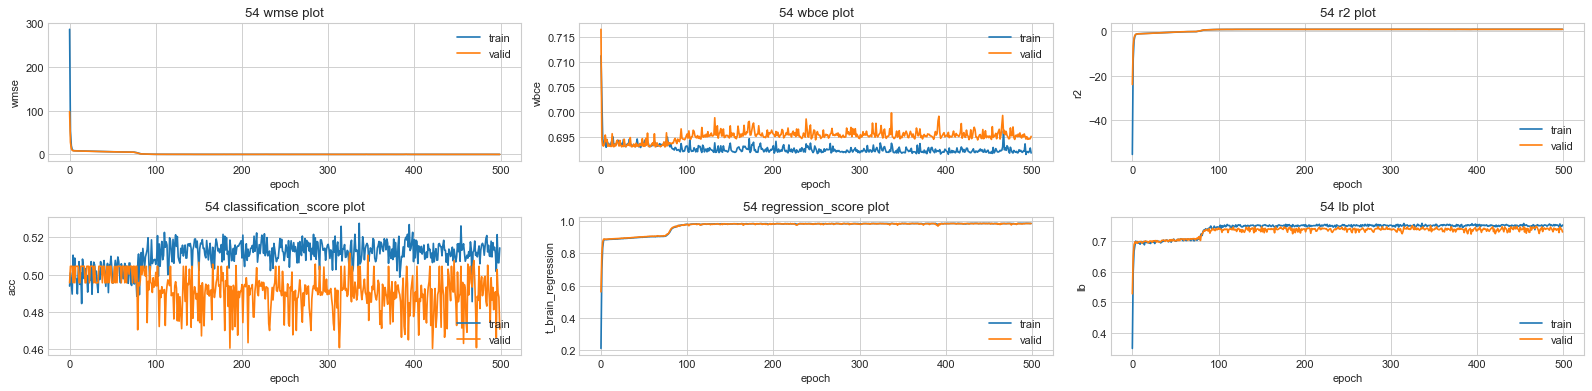

validation wbce: 0.695210
validation wmse: 0.168762
validation r2 : 0.960582
validation acc: 0.470881
validation regression: 0.985452
validation lb: 0.728167


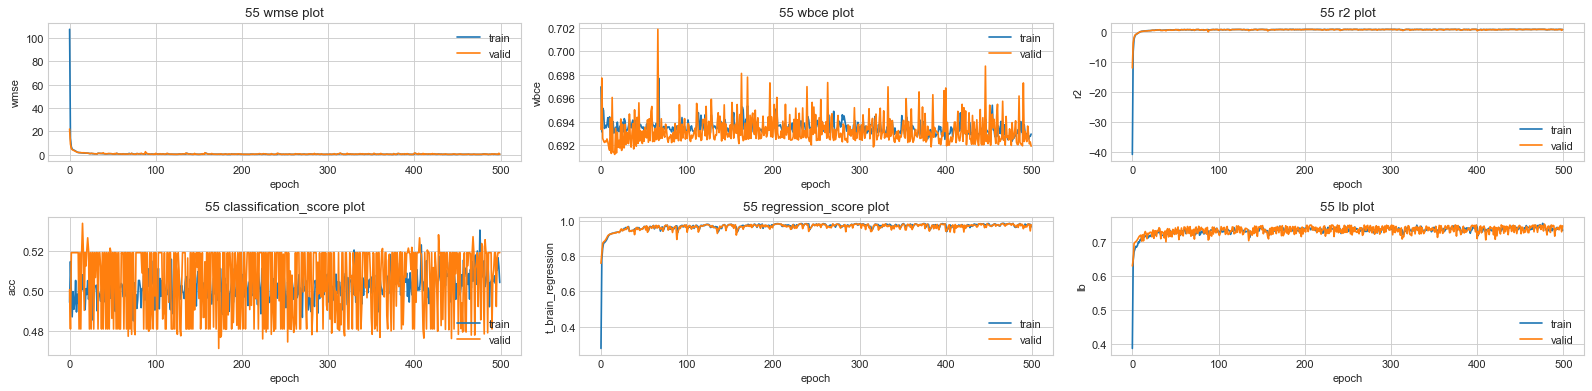

validation wbce: 0.691921
validation wmse: 0.186564
validation r2 : 0.925632
validation acc: 0.519157
validation regression: 0.977435
validation lb: 0.748296


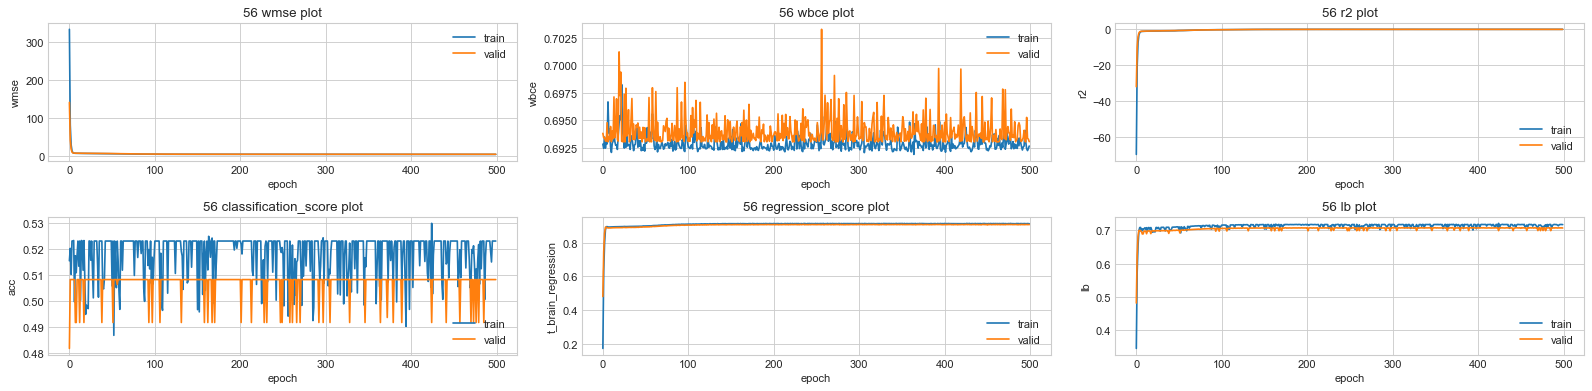

validation wbce: 0.693034
validation wmse: 5.572330
validation r2 : -0.045859
validation acc: 0.508238
validation regression: 0.905825
validation lb: 0.707031


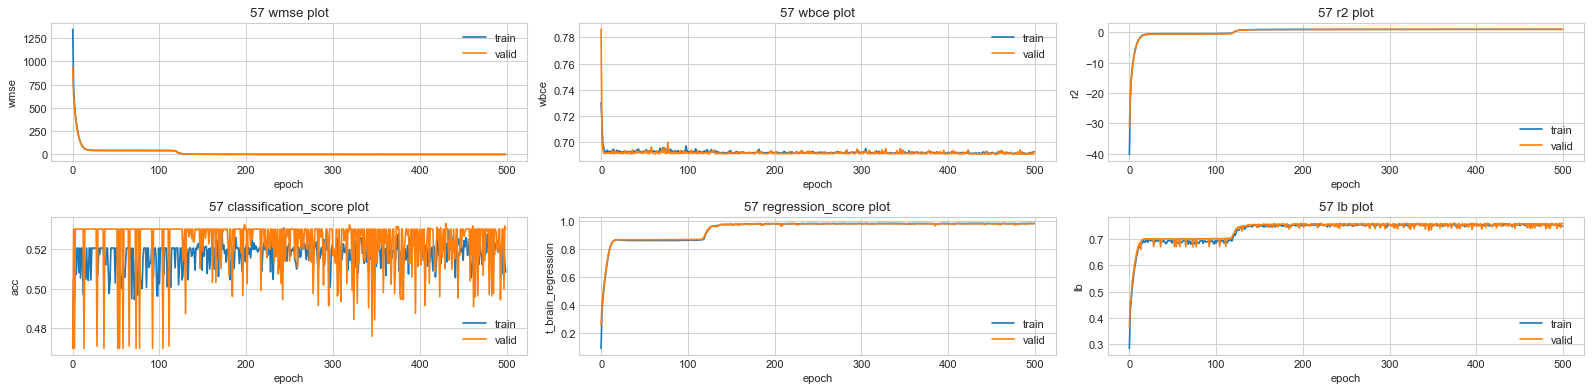

validation wbce: 0.691896
validation wmse: 0.729765
validation r2 : 0.971047
validation acc: 0.530077
validation regression: 0.985464
validation lb: 0.757770


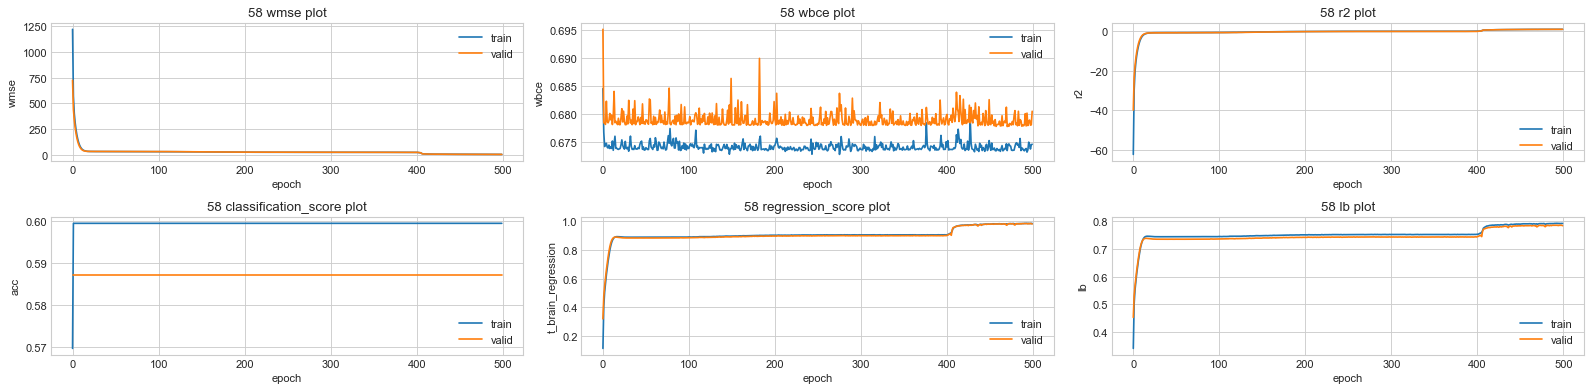

validation wbce: 0.680420
validation wmse: 1.126583
validation r2 : 0.924266
validation acc: 0.587165
validation regression: 0.980251
validation lb: 0.783708


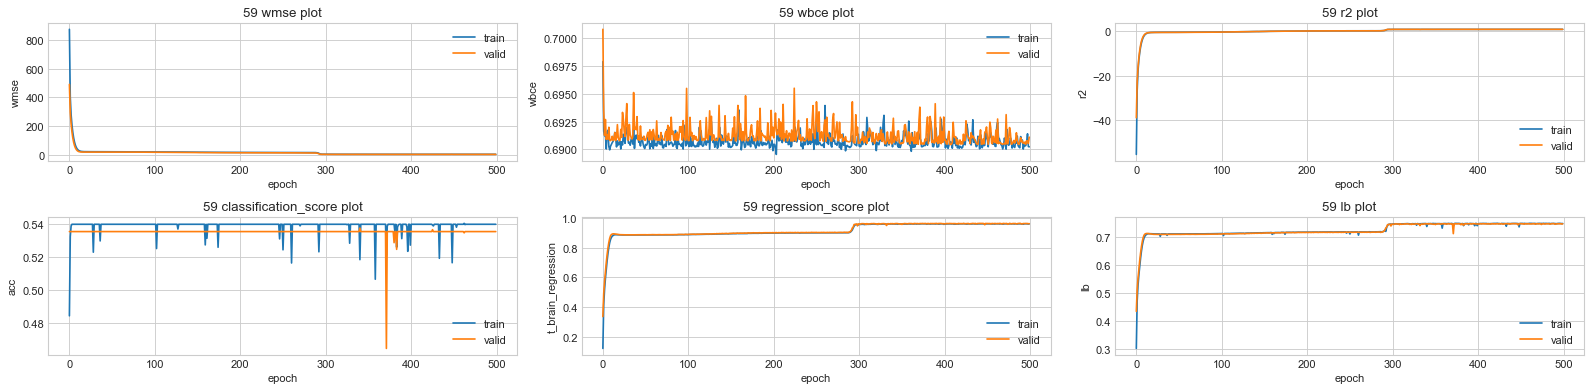

validation wbce: 0.691095
validation wmse: 3.821798
validation r2 : 0.601313
validation acc: 0.535249
validation regression: 0.960640
validation lb: 0.747944


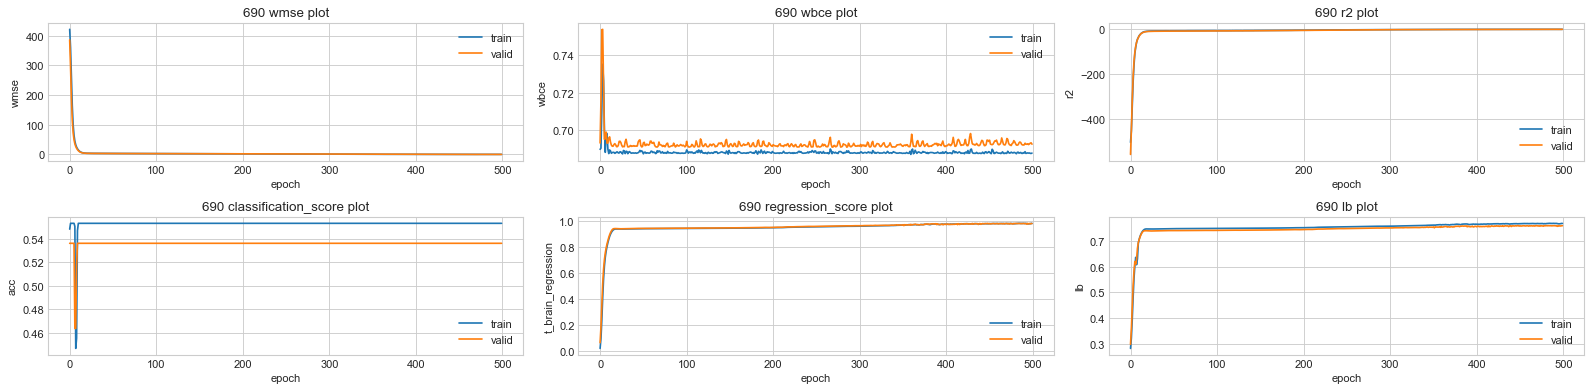

validation wbce: 0.692344
validation wmse: 0.302456
validation r2 : 0.531682
validation acc: 0.536111
validation regression: 0.979031
validation lb: 0.757571


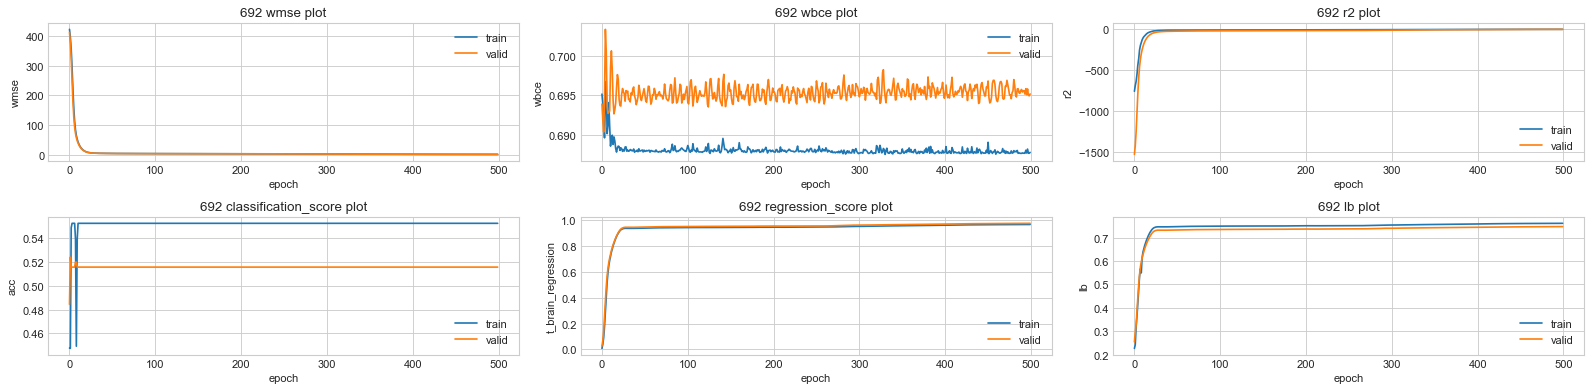

validation wbce: 0.695177
validation wmse: 0.357150
validation r2 : -0.636394
validation acc: 0.515625
validation regression: 0.977779
validation lb: 0.746702


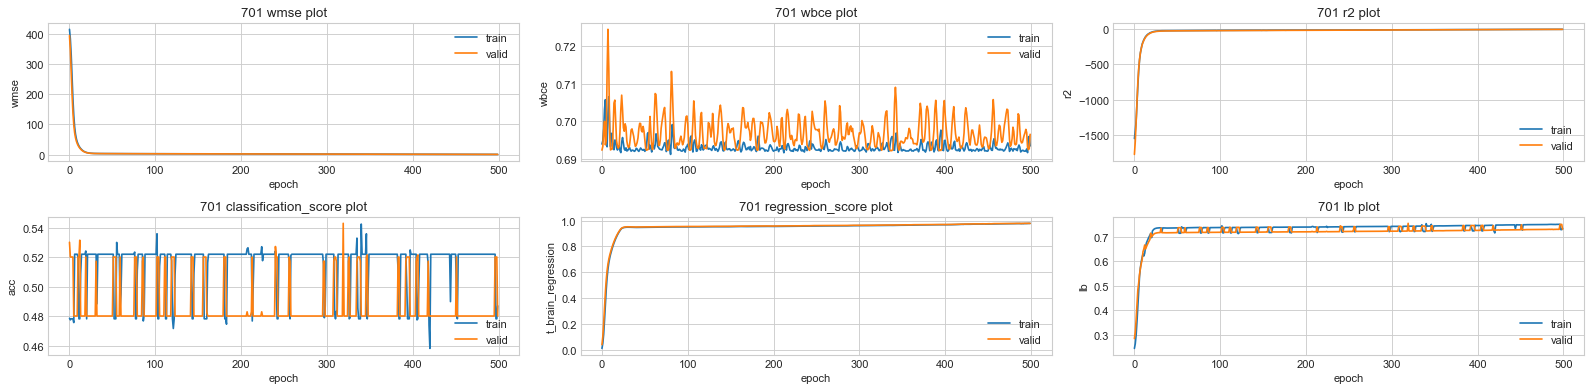

validation wbce: 0.696596
validation wmse: 0.419813
validation r2 : -2.231921
validation acc: 0.480000
validation regression: 0.979131
validation lb: 0.729565


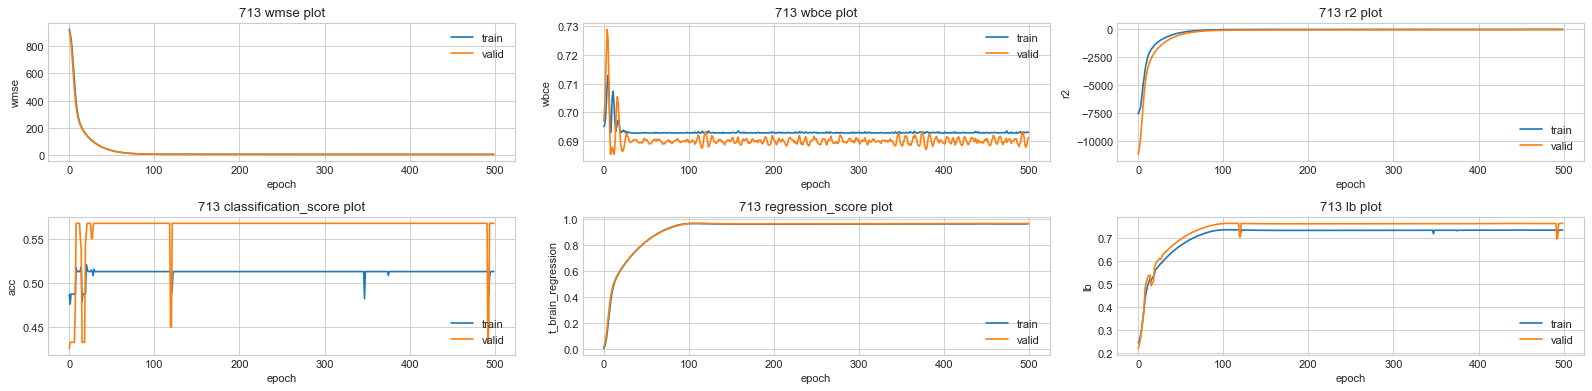

validation wbce: 0.691269
validation wmse: 4.807427
validation r2 : -111.931915
validation acc: 0.567241
validation regression: 0.963647
validation lb: 0.765444


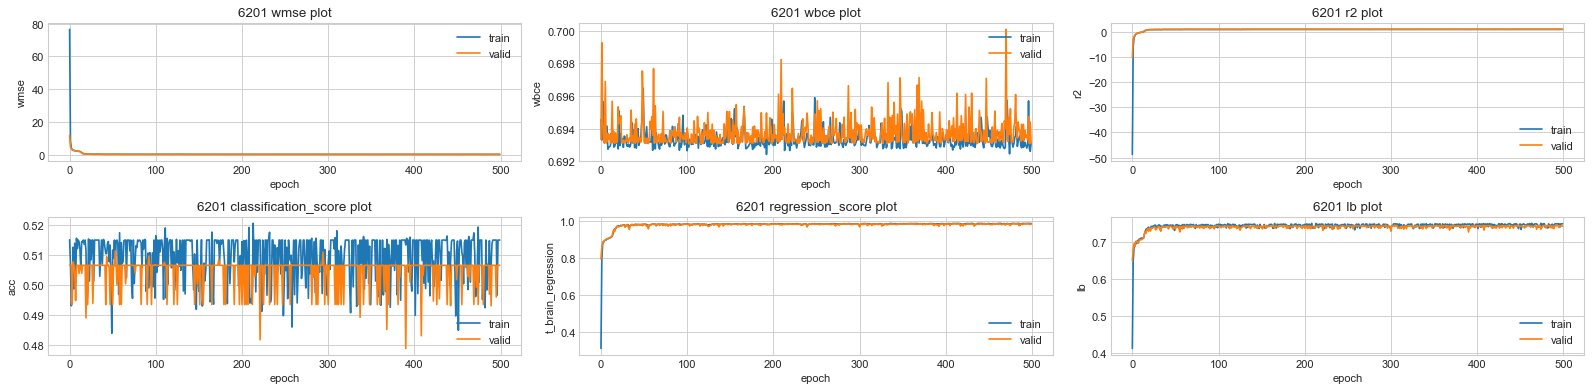

validation wbce: 0.693089
validation wmse: 0.102588
validation r2 : 0.931416
validation acc: 0.506513
validation regression: 0.979063
validation lb: 0.742788


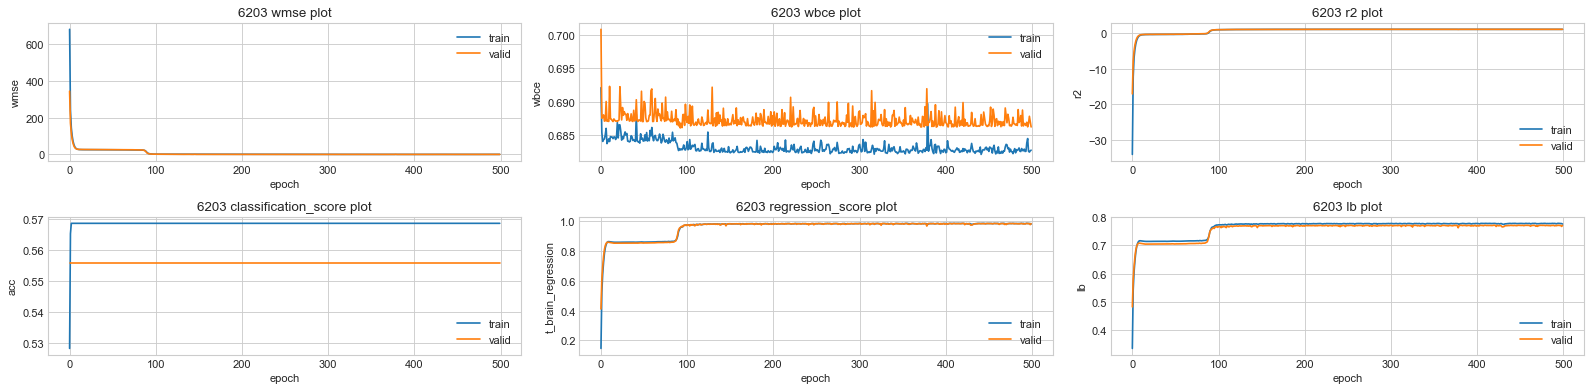

validation wbce: 0.686239
validation wmse: 0.385491
validation r2 : 0.976985
validation acc: 0.555556
validation regression: 0.985393
validation lb: 0.770474


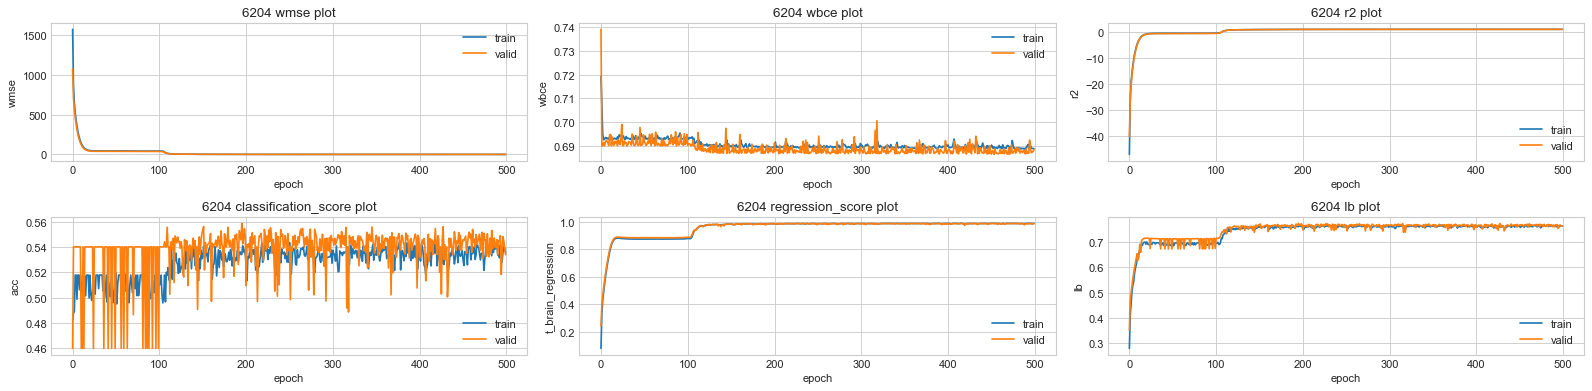

validation wbce: 0.688488
validation wmse: 0.762262
validation r2 : 0.968153
validation acc: 0.533908
validation regression: 0.985486
validation lb: 0.759697


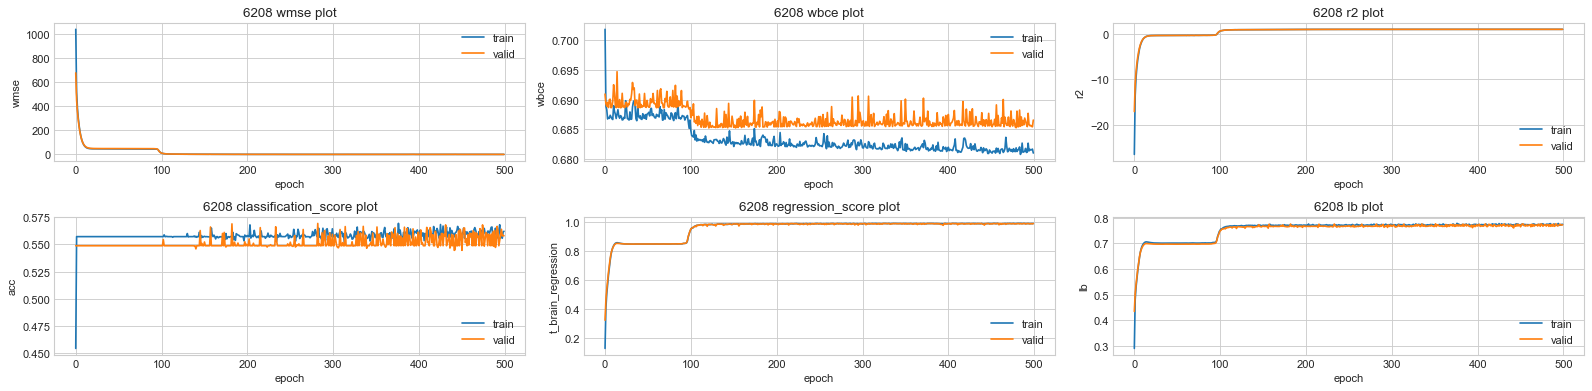

validation wbce: 0.686580
validation wmse: 0.623210
validation r2 : 0.979756
validation acc: 0.558046
validation regression: 0.986461
validation lb: 0.772253


In [11]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
total_lb = None
total_vlb = None
for model_n, (X, Y, label) in enumerate(train_18):
    X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X, Y, label, test_size=0.2)
    prefix = str(codes[model_n])
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss={'regression':regress_loss, 'class':classification_loss}, optimizer='adam', metrics = {'regression':[r2_keras, regression_score], 'class':[classification_score]}, loss_weights={'class':2, 'regression':1})
    history = model.fit(X_train, [Y_train, label_train], validation_data=(X_test, [Y_test, label_test]) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs')], shuffle=True, verbose=0)
    vis(history, title=prefix, dpi=180)
    print('validation wbce: {:.6f}'.format(history.history['val_class_loss'][-1]))
    print('validation wmse: {:.6f}'.format(history.history['val_regression_loss'][-1]))
    print('validation r2 : {:.6f}'.format(history.history['val_regression_r2_keras'][-1]))
    print('validation acc: {:.6f}'.format(history.history['val_class_classification_score'][-1]))
    print('validation regression: {:.6f}'.format(history.history['val_regression_regression_score'][-1]))
    print('validation lb: {:.6f}'.format(0.5*history.history['val_regression_regression_score'][-1]+0.5*history.history['val_class_classification_score'][-1]))
    lb = 0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score'])
    val_lb = 0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score'])
    if total_lb is None: # compute total lb and plot lb plot
        total_lb = lb
        total_vlb = val_lb
    else:
        total_lb = total_lb + lb
        total_vlb = total_vlb + val_lb
    model.save(prefix+'_model.h5')
    K.clear_session()

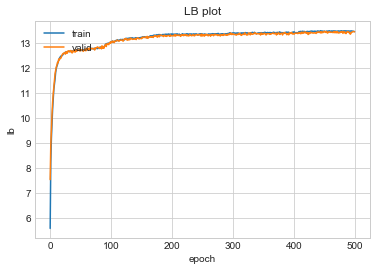

Overall training lb: 13.467554
Overall validation lb: 13.458157


In [12]:
plt.plot(total_lb)
plt.plot(total_vlb)
plt.title('LB plot')
plt.ylabel('lb')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()
print('Overall training lb: {:.6f}'.format(total_lb[-1]))
print('Overall validation lb: {:.6f}'.format(total_vlb[-1]))

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
